In [1]:
# Importing packages
from collections import deque, namedtuple
import time, random
import heapq
import os
import matplotlib.pyplot as plt

# Setting up logger
import logging, importlib
import time

inf = float('inf')
time_threshold = 10000
original_capacity = 1
original_cost = 1
long_link_cost = 1000
rebuild_probability = 0.25
number_of_nodes = 32

number_of_source_destination_pairs = 50
number_of_samples = 1000

In [2]:
def dist(graph, start_node, end_node):
    return min((start_node - end_node) % len(graph.vertices), (end_node - start_node) % len(graph.vertices))


def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)


def reduce_edges(edge_list: list):
    local_dictionary = {}
    local_list = []
    for (start, end, capacity) in edge_list:
        if (start, end) in local_dictionary:
            local_dictionary[(start, end)] += capacity
        else:
            local_dictionary[(start, end)] = capacity
    for edge, capacity in local_dictionary.items():
        local_list.append((edge[0], edge[1], capacity))
    return local_list


class Vertex:
    def __init__(self, vertex):
        self.name = vertex
        self.neighbours = {}
        self.local_knowledge = None

    # Storing the indices of neighbouring vertices
    def add_neighbour(self, neighbour, capacity=1):
        if neighbour not in self.neighbours:
            self.neighbours[neighbour] = capacity
        else:
            return False

    def add_neighbours(self, neighbours):
        for neighbour in neighbours:
            if isinstance(neighbour, tuple):
                self.add_neighbour(neighbour[0], neighbour[1])
            else:
                self.add_neighbour(neighbour)

    def add_local_knowledge(self, graph):
        self.local_knowledge = graph

    def __repr__(self):
        return str(self.neighbours)


class Graph:

    # Check that the arguments are valid
    # edges: list of edges awaited in the format of list(tuple(start_node, end_node, capacity))
    def __init__(self, edges: list = None, bidirectional=True):
        self.Vertices = {}
        self.bidirectional = bidirectional

        # Initializing graph based on edges
        if edges is not None:
            # wrong_edges = [i for i in edges if len(i) not in [2, 4]]
            # if wrong_edges:
            #    raise ValueError('Wrong edges data: %s', wrong_edges)

            # Adding bidirectional links
            for (start_node, end_node, capacity) in edges:

                # Adding onward link
                if start_node not in self.Vertices.keys():
                    self.Vertices[start_node] = Vertex(start_node)

                self.Vertices[start_node].add_neighbour(end_node, capacity)

                # Adding backward link
                if end_node not in self.Vertices.keys():
                    self.Vertices[end_node] = Vertex(end_node)

                self.Vertices[end_node].add_neighbour(start_node, capacity)

    @property
    def vertices(self):
        return self.Vertices

    def vertex(self, vertex):
        try:
            self.vertices[vertex]
        except:
            log.debug("No such start node found among the vertices.")
        return self.vertices[vertex]

    def add_vertex(self, vertex):
        if isinstance(vertex, Vertex):
            self.Vertices[vertex.name] = vertex.neighbours

    def add_vertices(self, vertices):
        for vertex in vertices:
            self.add_vertex(vertex)

    def add_edge(self, vertex_from, vertex_to):
        if isinstance(vertex_from, Vertex) and isinstance(vertex_to, Vertex):
            vertex_from.add_neighbour(vertex_to)
            if isinstance(vertex_from, Vertex) and isinstance(vertex_to, Vertex):
                self.Vertices[vertex_from.name] = vertex_from.neighbours
                self.Vertices[vertex_to.name] = vertex_to.neighbours

    def add_edges(self, edges):
        for edge in edges:
            self.add_edge(edge[0], edge[1])

    def add_capacity(self, start_node: int, end_node: int, capacity: int):
        try:
            self.vertices[start_node]
        except KeyError:
            log.debug("No such start node found among the vertices.")
        try:
            self.vertices[start_node].neighbours[end_node]
        except KeyError:
            log.debug("No such end node found among the vertices.")
        self.vertices[start_node].neighbours[end_node] += 1

    def get_edge_capacity(self, start_node, end_node):

        try:
            self.vertices[start_node]
        except KeyError:
            log.debug("No such start node found among the vertices.")
        try:
            self.vertices[start_node].neighbours[end_node]
        except KeyError:
            log.debug("No such end node found among the vertices.")
        return self.vertices[start_node].neighbours[end_node]

    def remove_virtual_link(self, start_node, end_node):

        if self.get_edge_capacity(start_node, end_node) != 0:
            self.vertices[start_node].neighbours[end_node] -= 1
        if self.get_edge_capacity(end_node, start_node) != 0:
            self.vertices[end_node].neighbours[start_node] -= 1

    def get_number_of_unavailable_virtual_links(self):
        number_of_zero_capacity_links = 0
        for x in self.vertices.keys():
            number_of_zero_capacity_links += sum([1 for x in self.vertices[x].neighbours.values() if x == 0])
        if self.bidirectional:
            return number_of_zero_capacity_links / 2
        else:
            return number_of_zero_capacity_links

    def add_local_knowledge(self, local_knowledge_graph_edges: list):
        for node in self.vertices:
            local_knowledge_graph = Graph(local_knowledge_graph_edges)
            self.Vertices[node].add_local_knowledge(local_knowledge_graph)

    def remove_from_local_knowledge(self, update_along_edges: list):
        current_path = deque(update_along_edges)
        start_node = current_path.popleft()

        while len(current_path) > 0:
            end_node = current_path.popleft()
            self.remove_virtual_link(start_node, end_node)
            start_node = end_node


def traceback_path(target, parents) -> list:
    path: list = []
    while target:
        path.append(target)
        target = parents[target]
    return path


class HeapEntry:
    def __init__(self, node, distance):
        self.node = node
        self.distance = distance

    def __lt__(self, other):
        return self.distance < other.distance


# Calculating tentative cost
# Using hardcoded value of 1 as a cost (unique costs need to be stored for each edge)

# Using different cost function if the capacity is 0 (cost is defined as 1000)

def weight(graph: Graph, start: int, end: int):
    if graph.get_edge_capacity(start, end) == 0:
        return long_link_cost * dist(graph, start, end)
    else:
        return original_cost


# The Dijkstra algorithm with a support for rebuilding the best next hop
def dijkstra(graph: Graph, start: int, finish: int) -> list:
    open_nodes = [HeapEntry(start, 0.0)]
    closed_nodes = set()
    parents = {start: None}
    distance = {start: 0.0}

    while open_nodes:
        current = heapq.heappop(open_nodes).node

        if current is finish:
            return traceback_path(finish, parents)

        if current in closed_nodes:
            continue

        closed_nodes.add(current)

        # For every child of the current node (taking the neighbours)
        for child in graph.vertices[current].neighbours.keys():
            if child in closed_nodes:
                continue

            tentative_cost = distance[current] + weight(graph, current, child)

            if child not in distance.keys() or distance[child] > tentative_cost:
                distance[child] = tentative_cost
                parents[child] = current
                heap_entry = HeapEntry(child, tentative_cost)
                heapq.heappush(open_nodes, heap_entry)


'''
Processes a source-destination pair of distance one of the current path
by checking the capacity of the link between the start and the end node

If the capacity is 0, then a probabilistic rebuild approach is used

Returns the elapsed time that was needed to process the particular source-destination pair

If the capacity of the link is 0, then
do probabilistic rebuilding

Otherwise: 
Consumes a link from the remaining ones
Alternatively: add the threshold waiting time for rebuilding
'''


def entanglement_swap(graph, start_node, end_node):
    local_edt = 0
    local_no_link_dist = 0

    if graph.get_edge_capacity(start_node, end_node) == 0:

        local_no_link_dist += dist(graph, start_node, end_node)
    else:

        # Remove the link between startNode and endNode
        graph.remove_virtual_link(start_node, end_node)

        # Incrementing the entanglement delay time
        local_edt += 1

    return local_edt, local_no_link_dist


'''
# Works through a source-destination pair by traversing through the nodes in between and adding the elapsed time
#
# Calls on the entanglement_swap method as many times as big the distance between the source and the destination is
'''


def distribute_entanglement(graph, current_path_list):
    # Initializing entanglement delay time
    edt = 0
    no_link_dist = 0
    current_path = deque(current_path_list)
    initial_node = current_path.popleft()
    get_initial = True

    # Take the leftmost two nodes out of the deque and get the edt until we are finished

    while True:
        if get_initial:
            start_node = initial_node
            get_initial = False
        else:
            start_node = current_path.popleft()
        end_node = current_path.popleft()

        # Calculate the edt for the current step
        local_temp1, local_temp2 = entanglement_swap(graph, start_node, end_node)
        edt += local_temp1
        no_link_dist += local_temp2

        # Check if we have processed the path
        if len(current_path) == 0:
            if no_link_dist > 0:

                # If we cannot create the missing entangled links in the specific threshold time
                # Then simply generate entangled links along the physical graph
                if time_threshold < ((1 / rebuild_probability) ** no_link_dist):
                    return (1 / rebuild_probability) ** dist(graph, initial_node, end_node)
                else:
                    return edt + ((1 / rebuild_probability) ** no_link_dist)
            else:
                return edt

        # Put the end node back into the deque
        current_path.appendleft(end_node)


# Distributing entanglement based on the generated source destination pairs
# Processes these pairs by calling the distribute_entanglement method on the next path
# Distributes entanglement for each of the paths stored in the deque and pushes the result edt into a store
def calculate_wt_for_paths(graph, paths):
    edt_store = []
    number_of_unavailable_virtual_links_store = []

    while True:

        current_path = paths.popleft()
        edt_store.append(distribute_entanglement(graph, current_path))
        number_of_unavailable_virtual_links_store.append(graph.get_number_of_unavailable_virtual_links())

        if len(paths) == 0:
            return edt_store, number_of_unavailable_virtual_links_store


# Generates random source-destination pairs
# The number of source-destination pairs is given by the argument
def gen_rand_pairs(number_of_pairs):
    result = []
    for x in range(number_of_pairs):
        source = random.randint(1, number_of_nodes)
        dest = random.randint(1, number_of_nodes)
        while source == dest:
            dest = random.randint(1, number_of_nodes)
        result += [[source, dest]]
    return result


# 1. Generates source-destination pairs
# 2. Finds the nodes in between the SD pairs by calling on the shortest path method
def initialize_paths(graph: Graph, number_of_source_destination_pairs: int):
    # Generate random pairs of nodes between which we are seeking a path
    randPairs = gen_rand_pairs(number_of_source_destination_pairs)

    # Assemble paths into one deque
    paths = deque()
    for pair in randPairs:
        paths.appendleft(dijkstra(graph, pair[0], pair[1]))
    return paths


# Create paths for the specified number of source and destination pairs, then send the packets along a specific path
# and store the waiting time and the distance
# graph: the graph in which we send the packets
# number_of_source_destination_pairs: number of source and destination pairs for which we are creating a path
def dijkstra_init(graph_edges: list, number_of_source_destination_pairs: int, statistical_measure=mean):
    # Generate the specific graph object
    local_graph = Graph(graph_edges)

    # Initialize paths in advance, then processing them one by one
    # The change in network is not considered in this approach (path is NOT UPDATED)
    path_store = initialize_paths(local_graph, number_of_source_destination_pairs)

    # Storing the distances of the paths
    distance_store = []
    for x in path_store:
        distance_store.append(len(x))
    # Calculating the entanglement delay times
    edts_store, number_of_unavailable_virtual_links_store = calculate_wt_for_paths(local_graph, path_store)
    return statistical_measure(edts_store), statistical_measure(distance_store), statistical_measure(
        number_of_unavailable_virtual_links_store)


def global_algo(graph_edges: list, number_of_source_destination_pairs: int, statistical_measure=mean):
    # Generate the specific graph object
    local_graph = Graph(graph_edges)

    # Initialize store for waiting times
    edts_store = []

    # Initialize store for the distances of the paths
    distance_store = []

    # Initialize store for the number of unavailable links
    number_of_unavailable_virtual_links_store = []

    for x in range(1, number_of_source_destination_pairs + 1):

        source = random.randint(1, number_of_nodes)
        dest = random.randint(1, number_of_nodes)

        while source == dest:
            dest = random.randint(1, number_of_nodes)

        # Initialize path
        # The change in network is considered in this approach (path is UPDATED)
        current_path = deque(dijkstra(local_graph, source, dest))
        distance_store.append(len(current_path))
        edts_store.append(distribute_entanglement(local_graph, current_path))
        number_of_unavailable_virtual_links_store.append(local_graph.get_number_of_unavailable_virtual_links())
    return statistical_measure(edts_store), statistical_measure(distance_store), statistical_measure(
        number_of_unavailable_virtual_links_store)


# Execute the simulation for a distinct number of source and destination pairs multiple times
# graph: the graph in which we send the packets
# sd_pairs: number of source and destination pairs for which we are simulating for
# samples times: number of times we repeat the simulation
# algorithm: algorithm to be used to get the path and waiting time for a specific sd pair (default is Dijkstra)
def run_for_specific_source_destination_pair(graph_edges: list, sd_pairs: int, samples: int, algorithm=dijkstra_init,
                                             statistical_measure=mean):
    edts_store = []
    distance_store = []
    number_of_unavailable_virtual_links_store = []
    for x in range(1, samples + 1):
        edts, distances, number_of_unavailable_virtual_links = algorithm(graph_edges, sd_pairs, statistical_measure)
        edts_store.append(edts)
        distance_store.append(distances)
        number_of_unavailable_virtual_links_store.append(number_of_unavailable_virtual_links)
    return statistical_measure(edts_store), statistical_measure(distance_store), statistical_measure(
        number_of_unavailable_virtual_links_store)


# Simulation for more than one run of the loop_for_specific_sd_pair
def run_for_specific_graph(graph_edges: list, sd_pairs: int, samples: int, algorithm=dijkstra_init,
                           statistical_measure=mean):
    edts_store = []
    distance_store = []
    number_of_unavailable_virtual_links_store = []

    # Iterating through the remaining simulation rounds
    for x in range(1, sd_pairs + 1):
        next_edts, next_distances, next_number_of_zero_capcity_links = run_for_specific_source_destination_pair(
            graph_edges, x, samples, algorithm, statistical_measure)

        # Summing up the values obtained in each round
        edts_store.append(next_edts)
        distance_store.append(next_distances)
        number_of_unavailable_virtual_links_store.append(next_number_of_zero_capcity_links)

    # Returning the average of the result values
    return edts_store, distance_store, number_of_unavailable_virtual_links_store


def run_algorithm_for_graphs(graphs: list, number_of_sd_pairs, number_of_samples, algorithm=dijkstra_init,
                             statistical_measure=mean):
    return [run_for_specific_graph(graphs[graph_index], number_of_sd_pairs, number_of_samples, algorithm,
                                   statistical_measure) for graph_index in range(len(graphs))]


def log_graph_results(log: logging.Logger, graph_results: list, simulation_measures: list):
    for store_index in range(len(graph_results)):
        log.debug('-------------------------------------------------------------')
        log.debug(simulation_measures[store_index])
        log.debug('-------------------------------------------------------------')
        log.debug(graph_results[store_index])


def write_results_to_file(simulation_results: list, algorithm_name: str, approach: str, elapsed_time: int):
    importlib.reload(logging)
    logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')
    timestr = time.strftime("%y_%m_%d__%H_%M")

    # Create the logs directory, if it is non-existant yet
    directory = 'logs'
    if not os.path.exists(directory):
        os.makedirs(directory)

    fileh = logging.FileHandler('./' + directory + '/' + algorithm_name + '_' + str(number_of_samples) +
                                '_' + approach + '_' + timestr + '.log', 'a')
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    fileh.setFormatter(formatter)

    log = logging.getLogger()  # root logger
    for hdlr in log.handlers[:]:  # remove all old handlers
        log.removeHandler(hdlr)
    log.addHandler(fileh)  # set the new handler

    # Names of simulation measures
    simulation_measures = ['Average waiting times:', 'Average distances:',
                           'Number of links with zero capacities:']

    if '' == approach:
        log.debug('Logging the simulation results of the ' + algorithm_name + ' algorithm.')
    else:
        log.debug(
            'Logging the simulation results of the ' + algorithm_name + ' algorithm (using the ' + approach + '.')
    log.debug('The simulation measures are as follows: ')
    log.debug(simulation_measures)
    log.debug('Detailed simulation results based on the graph measured: ')
    for graph_index in range(len(simulation_results)):
        log.debug('graph' + str(graph_index) + ':')

        # Log the stores containing the results
        log_graph_results(log, simulation_results[graph_index], simulation_measures)

    # Log the elapsed time
    log.debug('The elapsed time was: ' + str(elapsed_time))

def create_graph_with_local_knowledge(graph_edges:list):
    graph = Graph(graph_edges)
    graph.add_local_knowledge(graph_edges)
    return graph

def update_along_phyical_graph(main_graph: Graph, start_node: int, end_node: int, current_path: list):
    for index in range(0, dist(main_graph, start_node, end_node) + 1):
        main_graph.vertices[(start_node + index) % len(main_graph.vertices)]\
            .local_knowledge.remove_from_local_knowledge(current_path)


# Updates the local knowledge of the nodes along the physical graph
def update_local_knowledge(main_graph: Graph, current_path: list):
    start_node = current_path[0]
    end_node = current_path[-1]

    # Determining which way will the local knowledge be propagated
    if (end_node - start_node) % len(main_graph.vertices) <= (start_node - end_node) % len(main_graph.vertices):
        update_along_phyical_graph(main_graph, start_node, end_node, current_path)
    else:
        update_along_phyical_graph(main_graph, end_node, start_node, current_path)

# ------------------------------------
# Implementing the local algorithms
# Nodes have knowledge about the graph based on the path discovery that they have participated in
def local_knowledge_algorithm(graph_edges: list, number_of_source_destination_pairs: int,
                              update_algorithm=update_local_knowledge, statistical_measure=mean):

    # Generate the specific graph object
    main_graph = create_graph_with_local_knowledge(graph_edges)

    # Initialize store for waiting times
    edts_store = []

    # Initialize store for the distances of the paths
    distance_store = []

    # Initialize store for the number of unavailable links
    number_of_unavailable_virtual_links_store = []

    for x in range(1, number_of_source_destination_pairs + 1):

        source = random.randint(1, number_of_nodes)
        dest = random.randint(1, number_of_nodes)

        while source == dest:
            dest = random.randint(1, number_of_nodes)

        # Initialize path
        # Determine shortest path based on local knowledge
        current_path = dijkstra(main_graph.vertices[source].local_knowledge, source, dest)
        distance_store.append(len(current_path))

        # Distribute entanglement in the main graph
        edts_store.append(distribute_entanglement(main_graph, current_path))

        # Update local knowledge of the nodes that are along the current path
        update_algorithm(main_graph, current_path)

        # Get the number of available virtual links the source node has knowledge about
        number_of_unavailable_virtual_links_store.append(main_graph.get_number_of_unavailable_virtual_links())
    return statistical_measure(edts_store), statistical_measure(distance_store), statistical_measure(
        number_of_unavailable_virtual_links_store)

In [3]:
def generate_graphs(number_of_nodes: int = 32, original_capacity:int = 1):
    # Initiating the edges of 0) type: 1->2, 2->3, ... 31->32, 32->1 (circular graph)
    graph0_edges = [(x, x + 1, 0) for x in range(1, number_of_nodes)] + [(number_of_nodes, 1, 0)]

    # Iniating the edges of 0) type: 1->2, 2->3, ... 31->32, 32->1 (circular graph)
    graph1_edges = [(x, x + 1, original_capacity) for x in range(1, number_of_nodes)] + [
        (number_of_nodes, 1, original_capacity)]

    # Iniating the edges of 1) type: 1->2, 3->4, ... 31->32
    # Odd number of nodes
    graph1_edges = graph1_edges + [(x, x + 1, original_capacity) for x in range(1, number_of_nodes + 1)
                                   if x % 2 == 1 and x < number_of_nodes and number_of_nodes % 2 == 1]

    # Even number of nodes
    graph1_edges = graph1_edges + [(x, (x + 1) % (number_of_nodes + 1), original_capacity) for x in
                                   range(1, number_of_nodes + 1) if x % 2 == 1 and x < number_of_nodes
                                   and number_of_nodes % 2 == 0]

    # Iniating the edges of 2) type: 1->2, 5->6, ... 29->30 (making up for the edges present in graph3)
    # Number of nodes have 0 as remainder for modulo 4
    graph1_edges = graph1_edges + [(x, x + 1, original_capacity) for x in range(1, number_of_nodes)
                                   if x % 4 == 1 and (x + 1) <= number_of_nodes] + [
                       (x, 1, original_capacity) for x in range(number_of_nodes - 1, number_of_nodes)
                       if x % 4 == 1 and (x + 1) > number_of_nodes]

    # Add up the multiple links:
    graph1_edges = reduce_edges(graph1_edges)

    # Iniating the edges of 0) type: 1->2, 2->3, ... 31->32, 32->1 (circular graph)
    graph2_edges = [(x, x + 1, original_capacity) for x in range(1, number_of_nodes)] + [
        (number_of_nodes, 1, original_capacity)]

    # Iniating the edges of 1) type: 1->3, 3->5, ... 31->1
    # Odd number of nodes
    graph2_edges = graph2_edges + [(x, x + 2, original_capacity) for x in range(1, number_of_nodes + 1)
                                   if x % 2 == 1 and x < number_of_nodes and number_of_nodes % 2 == 1]

    # Even number of nodes
    graph2_edges = graph2_edges + [(x, (x + 2) % number_of_nodes, original_capacity) for x in
                                   range(1, number_of_nodes + 1) if x % 2 == 1 and x < number_of_nodes
                                   and number_of_nodes % 2 == 0]

    # Adding additional long links to equal out the missing links compared to graph3
    # Iniating the edges of type: 1->3, 5->7, ... 29->31
    # Number of nodes have 0 as remainder for modulo 4
    graph2_edges = graph2_edges + [(x, x + 2, original_capacity) for x in range(1, number_of_nodes)
                                   if x % 4 == 1 and x + 2 <= number_of_nodes] + [
                       (x, 2 - (number_of_nodes - x), original_capacity) for x in range(1, number_of_nodes)
                       if x % 4 == 1 and (x + 2) > number_of_nodes]

    graph2_edges = reduce_edges(graph2_edges)

    # Initiating the edges of 0) type: 1->2, 2->3, ... 31->32, 32->1 (circular graph)
    graph3_edges = [(x, x + 1, original_capacity) for x in range(1, number_of_nodes)] + [
        (number_of_nodes, 1, original_capacity)]

    # Initiating the edges of 1) type: 1->3, 3->5, ... 31->1
    # Even number of nodes
    graph3_edges = graph3_edges + [(x, (x + 2) % number_of_nodes, original_capacity) for x in
                                   range(1, number_of_nodes + 1)
                                   if x % 2 == 1 and x < number_of_nodes and number_of_nodes % 2 == 0]
    # Odd number of nodes
    graph3_edges = graph3_edges + [(x, x + 2, original_capacity) for x in range(1, number_of_nodes + 1)
                                   if x % 2 == 1 and x < number_of_nodes and number_of_nodes % 2 == 1]

    # Initiating the edges of 2) type: 1->5, 5->9, ... 29->1
    # Number of nodes have 1 as remainder for modulo 4 (with indices smaller than or equal to the number of nodes)
    graph3_edges = graph3_edges + [(x, x + 4, original_capacity) for x in range(1, number_of_nodes)
                                   if x % 4 == 1 and x + 4 <= number_of_nodes]

    # Add the last link as well, that connects the greatest node with an index of 1 as remainder modulo 4 in distance
    graph3_edges = graph3_edges + [(x, 4 - (number_of_nodes - x), original_capacity) for x in range(1, number_of_nodes)
                                   if x % 4 == 1 and (x + 4) > number_of_nodes]

    return graph0_edges, graph1_edges, graph2_edges, graph3_edges

In [4]:
print(generate_graphs()[3])

[(1, 2, 1), (2, 3, 1), (3, 4, 1), (4, 5, 1), (5, 6, 1), (6, 7, 1), (7, 8, 1), (8, 9, 1), (9, 10, 1), (10, 11, 1), (11, 12, 1), (12, 13, 1), (13, 14, 1), (14, 15, 1), (15, 16, 1), (16, 17, 1), (17, 18, 1), (18, 19, 1), (19, 20, 1), (20, 21, 1), (21, 22, 1), (22, 23, 1), (23, 24, 1), (24, 25, 1), (25, 26, 1), (26, 27, 1), (27, 28, 1), (28, 29, 1), (29, 30, 1), (30, 31, 1), (31, 32, 1), (32, 1, 1), (1, 3, 1), (3, 5, 1), (5, 7, 1), (7, 9, 1), (9, 11, 1), (11, 13, 1), (13, 15, 1), (15, 17, 1), (17, 19, 1), (19, 21, 1), (21, 23, 1), (23, 25, 1), (25, 27, 1), (27, 29, 1), (29, 31, 1), (31, 1, 1), (1, 5, 1), (5, 9, 1), (9, 13, 1), (13, 17, 1), (17, 21, 1), (21, 25, 1), (25, 29, 1), (29, 1, 1)]


In [5]:
def plot_average_waiting_times(results: list, algo_name):
    timestr = time.strftime("%y_%m_%d__%H_%M")
    plt.plot(results[0][0],color='red', label="graph0")
    plt.plot(results[1][0],color='green', label="graph1 (dth=1)")
    plt.plot(results[2][0], color='blue', label="graph2 (dth=2)")
    plt.plot(results[3][0], color='purple', label="graph3 (dth=4)")
    plt.grid(color='b', linestyle='-', linewidth=0.1)
    plt.xlabel('Number of SD pairs')
    plt.ylabel('Average Time')
    plt.title('Algorithm:' + algo_name)
    plt.legend()

    # Create the logs directory, if it is non-existant yet
    directory = 'plots'
    if not os.path.exists(directory):
        os.makedirs(directory)

    plt.savefig('./' + directory + '/' + algo_name + '_' + str(number_of_samples) + '_' +'_' + timestr +'.png', bbox_inches='tight')

    plt.show()
    
def plot_average_distances(results: list, algo_name):
    timestr = time.strftime("%y_%m_%d__%H_%M")
    plt.plot(results[0][1],color='red', label="graph0")
    plt.plot(results[1][1],color='green', label="graph1 (dth=1)")
    plt.plot(results[2][1], color='blue', label="graph2 (dth=2)")
    plt.plot(results[3][1], color='purple', label="graph3 (dth=4)")
    plt.grid(color='b', linestyle='-', linewidth=0.1)
    plt.xlabel('Number of SD pairs')
    plt.ylabel('Distances')
    plt.title('Algorithm:' + algo_name)
    plt.legend()

    # Create the logs directory, if it is non-existant yet
    directory = 'plots'
    if not os.path.exists(directory):
        os.makedirs(directory)

    plt.savefig('./' + directory + '/' + algo_name + '_' + str(number_of_samples) + '_' +'_' + timestr +'_distances.png', bbox_inches='tight')
    plt.show()
    
def plot_unavailable_virtual_links(results: list, algo_name):
    timestr = time.strftime("%y_%m_%d__%H_%M")
    plt.plot(results[0][2],color='red', label="graph0")
    plt.plot(results[1][2],color='green', label="graph1 (dth=1)")
    plt.plot(results[2][2], color='blue', label="graph2 (dth=2)")
    plt.plot(results[3][2], color='purple', label="graph3 (dth=4)")
    plt.grid(color='b', linestyle='-', linewidth=0.1)
    plt.xlabel('Number of SD pairs')
    plt.ylabel('Number of links with a zero capacity')
    plt.title('Algorithm:' + algo_name)
    plt.legend()

    # Create the logs directory, if it is non-existant yet
    directory = 'plots'
    if not os.path.exists(directory):
        os.makedirs(directory)

    plt.savefig('./' + directory + '/' + algo_name + '_' + str(number_of_samples) + '_' +'_' + timestr +'_unavailable_virtual_links.png', bbox_inches='tight')
    plt.show()

def plot_results(results:list, title: str):
    plot_average_waiting_times(results, title)
    plot_average_distances(results, title)
    plot_unavailable_virtual_links(results, title)

In [6]:
start = time.time()
local_knowledge_results = run_algorithm_for_graphs(generate_graphs(),
                                                   number_of_source_destination_pairs,
                                                   number_of_samples)

end = time.time()

print('Runtime was:')
print(end - start)

Runtime was:
471.7087388038635


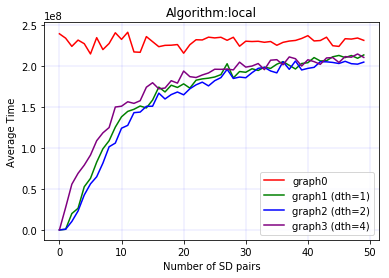

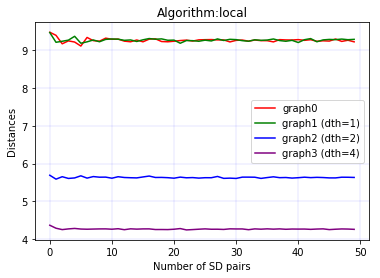

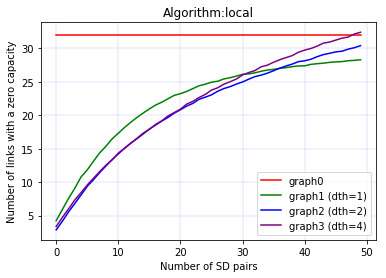

In [7]:
plot_results(local_knowledge_results, 'local')
write_results_to_file(local_knowledge_results, 'local','', (end - start))

In [4]:
import matplotlib.pyplot as plt
import os
import time

results_graph1 = [[8.2373, 3211217.793, 12933650.206766646, 29921165.9525, 44544464.77674003, 69309856.076717, 83013518.60344297, 97188670.7842875, 111320613.89651103, 122187381.3724898, 131698654.16963589, 140337562.6642997, 144415225.3636311, 153594737.99897826, 156940074.15328664, 162007529.871875, 165463711.93497616, 168363229.00651732, 173826850.0713313, 176465092.200195, 182411133.00303844, 181148092.5426492, 183668812.7153391, 184908534.5554629, 187868382.15549204, 186705444.70801505, 190469822.56484434, 189357439.81208888, 192388164.60403112, 195341659.37213424, 195185066.60212225, 195904959.8853469, 198397570.5871053, 199116785.28465602, 200938227.95532274, 201400442.01211482, 202352183.20516968, 202445741.20754665, 203253332.92608958, 202561456.81779507, 205109247.33300275, 206302851.06476608, 204687262.91496944, 207700611.9773139, 207576803.93668887, 206685421.31101435, 205455716.9260837, 208418513.59861487, 209122216.3277244, 207989348.46610743],
    [8.295, 1610663.585, 10709066.616000006, 27231550.89025, 40381166.53560006, 68960497.97300006, 81039314.41928579, 105933335.158875, 114234782.68888874, 123492497.15669999, 128597198.2175453, 141161079.79775003, 136143312.69738463, 149839119.49214292, 150097250.25466663, 157286145.0511875, 168685366.62123567, 173531653.13105577, 176538781.84752628, 177420191.74199992, 168922902.83361885, 179692523.67368189, 184525070.9844784, 191213911.18745837, 187637734.12952018, 191391771.2711924, 189336668.13185215, 182805470.70157176, 198925394.26468968, 200540073.89013347, 196112318.1724192, 189220492.0325625, 197964803.5726059, 199345241.9991471, 204547944.12502852, 198527682.6128888, 205216008.51759487, 203272538.1801842, 194564412.60092315, 213504899.55454993, 208949658.39278054, 209185287.91878578, 204869444.46406993, 210669549.3338862, 205543370.6704887, 202389556.31932592, 210239850.2147449, 207739159.53087494, 208454189.88379586, 209583929.5522001],
           [8.218, 12.6535, 5134265.833333339, 18157540.7515, 41820259.1906, 59050098.79566669, 78717257.20528564, 100684550.232625, 105977499.67055556, 127391288.65940012, 127343961.44772716, 137486913.32399994, 151515709.05961552, 150838568.00657147, 154959220.47779995, 164803101.457125, 174019484.17588237, 167577407.90883353, 174819889.95268437, 180250680.76570007, 179600984.8307142, 192109141.22640914, 182987823.57386965, 189287288.26345816, 186676603.29088005, 177143517.72488442, 185189073.36692598, 185451433.01550004, 197388982.7787931, 194104693.66423357, 196773668.74374178, 204812855.113375, 198369827.163182, 198555944.30267632, 201754686.48160037, 202799032.89500013, 200122681.38894624, 203943693.52344725, 201430468.30758977, 201957789.93717495, 201607653.98631704, 198696501.14071447, 205477827.7205116, 201311905.49704564, 207262654.0048888, 208564321.96802187, 206139377.5363619, 207375119.20562482, 213100430.22000006, 207858814.53778017]]

results_graph2 = [[4.4467, 7033017.99955, 20738518.506033357, 36835792.01995, 49823780.21385993, 62591595.173650086, 81856825.46035732, 97921558.8029125, 105326370.03925596, 116443443.58504024, 124911345.66780955, 136200055.3644742, 142857937.13888434, 147472441.44745058, 152199836.158539, 158222020.775275, 164181152.7618886, 165666618.9964113, 168534918.40863612, 172161426.2279392, 174482888.3050805, 178271552.9814587, 181483108.97668302, 181154866.04966643, 182534566.05108377, 185304015.9476608, 184676085.69513777, 187497794.05580726, 191346843.21855196, 192249624.47661072, 192169736.15442005, 192783367.1469875, 194721845.96785125, 199829601.9114175, 197174445.63678217, 199375512.28895268, 199486523.49171948, 200460328.17515498, 199200359.4233083, 201875692.1489229, 201403525.6155727, 205312438.5561216, 204351542.06132445, 205070757.4335259, 206082120.87192184, 204425389.39416075, 205415326.0066654, 204089246.88969725, 208278096.19108304, 205773491.25959626],
    [4.655, 134268.7855, 7858191.982999998, 25736473.09975, 36882131.24439998, 50993023.15233331, 73405236.86514291, 86821057.737125, 86433629.95833339, 99193724.39220005, 115416614.73027278, 124702501.40800008, 139404886.23669213, 139011926.4342857, 147857449.44986674, 152766787.59275, 151722042.96205878, 162776847.43655536, 170629905.67642134, 166019659.1627498, 170162597.73047602, 165553275.81945425, 176447966.91956514, 178633339.42504176, 180892791.96420017, 180940133.20203823, 186103729.82518494, 185905528.99774992, 182007688.146862, 187241823.24046686, 184181451.6218709, 187470217.886, 192298591.76475757, 196432681.22338244, 195166091.89805713, 192262929.21208346, 201461959.10697338, 200944354.41021046, 200064003.45897433, 195786056.8949251, 200838999.5794874, 200614843.41592848, 206318989.68690684, 200931296.96250004, 202535538.80817762, 208244756.01152185, 204914299.0029362, 204013405.21660388, 202483698.75859198, 202759751.3800199],
           [4.59, 4.621, 4.997999999999998, 8.8175, 1007756.3574, 3340394.8794999993, 16248294.372571424, 30871036.5375, 43968198.20977781, 51686606.94519995, 72993647.4512727, 85688727.77783328, 96755186.55730772, 106610896.99478568, 111193768.40973352, 121261966.73075, 125235609.08252962, 129715252.97350004, 138307893.4897895, 132291394.91714995, 139673483.51409516, 144679564.68931818, 150299824.88013068, 155090415.59716657, 154709897.85912016, 161587337.50015426, 162725122.80155545, 162820811.5394643, 167144242.09044817, 172193076.3533999, 171859986.47741935, 175094523.61025, 177710150.92436358, 183371084.11694136, 184244772.8232571, 179367781.97386092, 180330382.77148667, 184236880.47160518, 186867968.84192288, 185817815.12884992, 190756592.0582928, 194106945.48597625, 182877211.6387906, 184426741.92206836, 194530721.3248444, 189452385.16428247, 190671074.57851058, 190091626.58122903, 194069864.2138368, 193976365.68984017]]

results_graph3 = [[3.2574, 19713397.98295, 44202358.74450014, 61044355.2238, 79776988.47024, 95140875.32783322, 109039928.00838588, 123145251.6359125, 125808681.22982219, 135210160.80133998, 148895438.33949986, 153142975.49325, 158598014.97811508, 161572488.33378562, 167185983.01128787, 168052059.99960625, 175616634.1293888, 179460640.43022245, 177372271.11210525, 180339081.4899509, 186007850.25575766, 184536438.22605377, 190164600.25623524, 191732601.43908715, 194660979.11162665, 193636824.36087748, 198920636.94603297, 196557403.03402087, 199468481.16966605, 198608801.17032045, 199059523.14859036, 201173937.4942594, 201533625.21928343, 202371292.9746389, 204155064.44426602, 205055673.53202856, 204073052.1647411, 205996614.01596227, 207279271.0013001, 206956127.25404748, 207564952.55028772, 208209193.66745168, 208693597.86557907, 208249484.69052032, 208514299.5344252, 209665610.39275196, 211313529.3106034, 211122376.53953573, 212226124.197215, 212753676.46201706],
    [3.257, 18120689.5725, 41233551.89966667, 56699086.987, 75040467.50400004, 89895681.70999998, 111027738.7370002, 116274407.63975, 126151792.6815558, 136440635.8807001, 150038771.95718208, 142086700.25424996, 152372260.6367692, 176788340.55299997, 169971645.97513354, 169846404.994, 181592320.5162352, 168090335.39950025, 183474193.6826318, 190101367.0350999, 188453890.67661905, 178514085.11568162, 184088147.41956493, 178121433.88983342, 193622283.69804037, 196844445.10473064, 193195321.8690371, 188305435.63071427, 200438295.70889604, 192538133.07413372, 201147292.57309672, 200994018.02534375, 207580886.41581824, 202617105.9353532, 200282237.5049713, 212422549.594528, 207317665.9167838, 201915435.75494757, 206283549.14251274, 209276602.7745002, 213344169.80978045, 208294821.28226212, 207485734.3446282, 206537850.8322272, 208247161.96811086, 206517438.0845216, 207320180.2689784, 210503739.3837082, 207521706.21687785, 213033823.82970005],
           [3.291, 3.3435, 3.5893333333333315, 4.6445, 121013.30280000008, 1473345.106833334, 7434779.007714283, 20664151.222625, 26695219.636222273, 46310192.404000014, 56369731.70536363, 70939643.38124986, 78143482.41769233, 96938098.92499997, 100922838.16153339, 109693434.2655, 124713367.8499412, 118971934.99666668, 123675337.86163154, 140339268.88575006, 140531920.52028587, 142291992.04263648, 154552718.9930871, 142267444.65170842, 150266691.8282398, 161714830.27538452, 153145058.87022215, 161355312.6503215, 162256399.74348262, 166602820.0632332, 162093093.09177426, 172747641.38965625, 170172711.87921217, 170222685.2344709, 175726723.8177428, 176352979.05547217, 187937249.65897325, 179627443.13386843, 184955466.5308975, 187798914.88852522, 185363368.95965865, 186428334.68290466, 186798369.10197684, 186235281.8569772, 182927734.75742215, 188824874.1460654, 190718422.35389367, 191632222.45170826, 193083545.780857, 193042935.6565]]

number_of_samples = 1000

In [5]:
colours = ['red', 'green', 'blue', 'c', 'grey', 'pink']
def plot_algorithm_comparison(data: list, titles: list, colours: list, name_of_measure: str, name_of_topology: str):
    for data_index in range(len(data)):
        plt.plot(data[data_index],color=colours[data_index], label=titles[data_index])
    plt.grid(color='b', linestyle='-', linewidth=0.1)

    plt.xlabel('Number of SD pairs')
    plt.ylabel(name_of_measure)
    plt.title(name_of_topology)
    plt.legend()

    timestr = time.strftime("%y_%m_%d__%H_%M")
    
    # Create the plots directory, if it is non-existant yet
    directory = 'plots/comp_alg'
    if not os.path.exists(directory):
        os.makedirs(directory)

    plt.savefig('./'+ directory +'/comp' + name_of_topology + '_' + name_of_measure + str(number_of_samples) + '_' +'_' + timestr +'.png', bbox_inches='tight')
    plt.show()

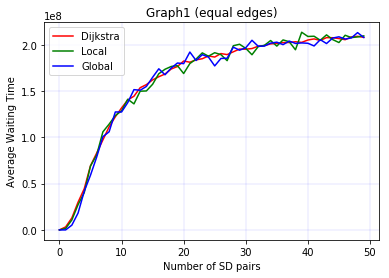

In [6]:
plot_algorithm_comparison(results_graph1, ['Dijkstra','Local', 'Global'], colours, 'Average Waiting Time', 'Graph1 (equal edges)')

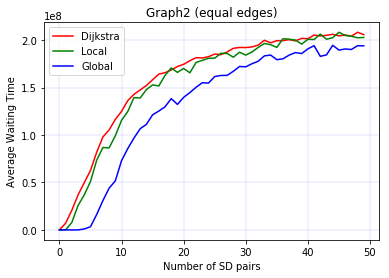

In [7]:
plot_algorithm_comparison(results_graph2, ['Dijkstra','Local', 'Global'], colours, 'Average Waiting Time', 'Graph2 (equal edges)')

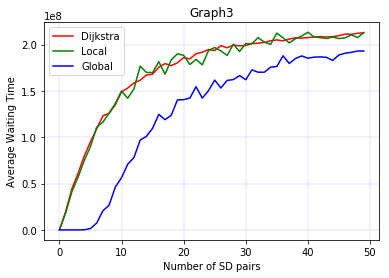

In [8]:
plot_algorithm_comparison(results_graph3, ['Dijkstra','Local', 'Global'], colours, 'Average Waiting Time', 'Graph3')

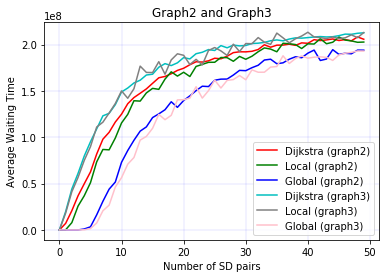

In [9]:
plot_algorithm_comparison(results_graph2 + results_graph3, ['Dijkstra (graph2)','Local (graph2)', 'Global (graph2)', 'Dijkstra (graph3)','Local (graph3)', 'Global (graph3)'], colours, 'Average Waiting Time', 'Graph2 and Graph3')

In [6]:
%%writefile myfile.py

UsageError: %%writefile is a cell magic, but the cell body is empty.
